## Introduction
Introduction about anaerobic microzones...

In this notebook we will build a 2D reactive transport model with heterogenous microzones that have different diffusion and reactive transport behavior. 

Import the standard libraries

In [1]:
# Import the flopy library
import flopy
# Import a few additional libraries
import sys
import os
import numpy as np
from scipy.special import erf as erf
from scipy.special import erfinv as erfinv
import matplotlib.pyplot as plt

flopy is installed in C:\ProgramData\Anaconda3\lib\site-packages\flopy


## Microzone (aggregate) size distributions
The microzones are areas of microporosity within our soil columns that may have different flow and transport properties. We will stochastically define the spatial extent of these microzones based on assumed lognormal microzone size distributions. These distributions are described below. Using the CDFs we can randomly sample over these distributions to populate our 2D model.

In [2]:
# lognormal probablility density function
def lognormal_pdf(r, sig_ag, mu_ag):
    pdf = 1/(r*sig_ag*(2*3.1415)**(1/2))*np.exp(-(np.log(r)-np.log(mu_ag))**2/(2*sig_ag**2))
    return pdf

# lognormal cumulative density function
def lognormal_cdf(r, sig_ag, mu_ag):
    cdf = 1/2 + 1/2* erf((np.log(r)-np.log(mu_ag))/(2**(1/2)*sig_ag))
    return cdf

# lognormal cumulative density function sampling
def sample_lognormal_cdf(zero2one, sig_ag, mu_ag):
    r = np.exp((2**(1/2)*sig_ag)*erfinv(2*zero2one-1) + np.log(mu_ag))
    return r

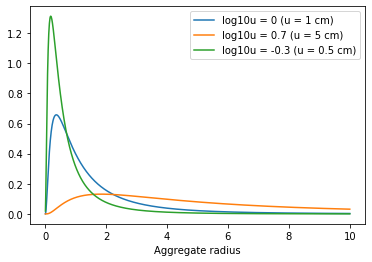

In [3]:
# microzone radius (cm)
r = np.linspace(0, 10, num=1000)
sig_ag = 1

fr_mu0 = lognormal_pdf(r, sig_ag, 1)
fr_mu07 = lognormal_pdf(r, sig_ag, 10**0.7)
fr_mun03 = lognormal_pdf(r, sig_ag, 10**-0.3)

# Plot it
c1, = plt.plot(r, fr_mu0, label='log10u = 0 (u = 1 cm)')
c2, = plt.plot(r, fr_mu07, label='log10u = 0.7 (u = 5 cm)')
c3, = plt.plot(r, fr_mun03, label='log10u = -0.3 (u = 0.5 cm)')
plt.xlabel('Aggregate radius')
plt.legend(handles=[c1, c2, c3])


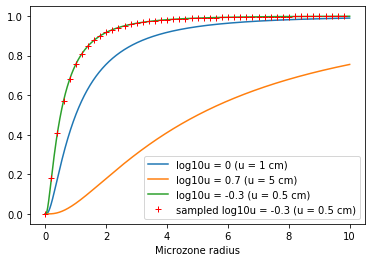

In [4]:
cdfr_mu0 = lognormal_cdf(r, sig_ag, 1)
cdfr_mu07 = lognormal_cdf(r, sig_ag, 10**0.7)
cdfr_mun03 = lognormal_cdf(r, sig_ag, 10**-0.3)
# Run this in reverse to check math, downsample for plot clarity
r_sample = sample_lognormal_cdf(cdfr_mun03[0:-1:20], sig_ag, 10**-0.3)

# Plot it
c1, = plt.plot(r, cdfr_mu0, label='log10u = 0 (u = 1 cm)')
c2, = plt.plot(r, cdfr_mu07, label='log10u = 0.7 (u = 5 cm)')
c3, = plt.plot(r, cdfr_mun03, label='log10u = -0.3 (u = 0.5 cm)')
c4, = plt.plot(r_sample, cdfr_mun03[0:-1:20], 'r+', label='sampled log10u = -0.3 (u = 0.5 cm)')
plt.xlabel('Microzone radius')
plt.legend(handles=[c1, c2, c3, c4])

## 2D model microzone distribution

Using the distributions of microzone size that we defined in the previous section, we will now generate a 2D distribution of microzones for inputing into our reactive transport model. The zones will be randomly distributed but have sizes drawn from a give lognormal distribution.

First let's define a grid and grid size.

In [5]:
# Grid size (cm)
grid_size = [1, 1]

nrow = 140 # number of rows (depth of model)
ncol = 200 # number of columns (width of model)

def grid_generation(grid_size, nrow, ncol):
    Lx = (ncol - 1) * grid_size[1]   # length of model in selected units 
    Ly = (nrow - 1) * grid_size[0]   # length of model in selected units 
    y, x = np.mgrid[slice(0, Ly + grid_size[0], grid_size[0]),
                slice(0, Lx + grid_size[1], grid_size[1])]
    xc = x[0,:] + grid_size[1]/2 
    yc = y[:,0] + grid_size[0]/2 
    return x, y, xc, yc

Now let's generate random microzone locations with a give lognormal size distribution. Column 1 is the center in x-direction, column 2 will center of microzone in y-direction, and column 3 will be microzone radius sampled using
the CDF function defined above. All values are in units of centimeters.

In [34]:
# Generate the model grid
x, y, xc, yc = grid_generation(grid_size, nrow, ncol)

# Now generate random microzone locations with statistical distribution
microzones = np.random.rand(500,3)
microzones[:,0] = microzones[:,0]*np.max(x)
microzones[:,1] = microzones[:,1]*np.max(y)

# call our CDF function using the randomly generate values from 0-1 to sample this CDF
microzones[:,2] = sample_lognormal_cdf(microzones[:,2], 1, 10**-0.3)

print(microzones)

[[105.59260795 134.64014853   0.31315517]
 [167.69094534 102.20912967   0.21593259]
 [ 31.6839242   16.2892779    0.36594635]
 ...
 [125.54164563 118.90924577   0.49448229]
 [ 67.64943707  89.71999602   0.94715783]
 [ 94.63872561   1.78826896   5.15949519]]


In [7]:
# microzone locations
def microzone_map_generation_function(microzones, nrow, ncol):
    # Define a map of zeros, the values at the location of microzones will be switch to ones
    microzone_map = np.zeros([1, nrow, ncol])
    # Determine the number of microzones (rows in microzone array)
    microzone_shape = np.shape(microzones)
    # Iterate through microzones
    for row in range(microzone_shape[0]):
        xrange = np.where(np.logical_and(
            xc>= (microzones[row,0] - microzones[row,2]), 
            xc<= (microzones[row,0] + microzones[row,2])))

        yrange = np.where(np.logical_and(
            yc>= (microzones[row,1] - microzones[row,2]), 
            yc<= (microzones[row,1] + microzones[row,2])))
        
        # if there are grid cell centers within the microzone then 
        if (np.size(xrange) > 0) and (np.size(yrange) > 0):
            # loop through x values
            for i in np.nditer(xrange):
                # loop through y values
                for j in np.nditer(yrange):
                    # find linear distance from grid center to microzone center
                    rc = ((xc[i] - microzones[row,0])**2 + 
                      (yc[j] - microzones[row,1])**2)**(1/2)
        
                    if rc<= microzones[row,2]:
                        microzone_map[0, j, i] = 1
                    
    return microzone_map

In [8]:
# Before going any further let's define a function for plotting 2D scalar fields
def plot_2d(map_data, x, y, colorbar_label):
    print(np.shape(map_data[::-1]))
    fs =16 # fontsize
    fig2 = plt.figure(figsize=(10, 10*np.max(y)/np.max(x))) # adjust these numbers to change the size of your figure
    ax = fig2.add_subplot(1, 1, 1, aspect='equal')
    # Use 'pcolor' function to plot 2d map of concentration
    # Note that we are flipping map_data and the yaxis to so that y increases downward
    imp = plt.pcolor(x, y, map_data, cmap='OrRd', edgecolors='k', linewidths=0.2)
#     imp = plt.pcolor(x, y, map_data[::-1], cmap='OrRd', edgecolors='k', linewidths=0.2)
    # color limit range from 0 to 1
#     plt.clim(0,1)
    # add a colorbar
    cbar = plt.colorbar() 
    # label the colorbar
    cbar.set_label(colorbar_label, fontsize=fs)
    # make colorbar font bigger
    cbar.ax.tick_params(labelsize= (fs-2)) 
    # make axis fontsize bigger!
    plt.tick_params(axis='both', which='major', labelsize=fs)
    # Label x-axis
    plt.ylabel('Soil column depth [cm]', fontsize=fs)
#     plt.gca().invert_yaxis()

In [35]:
# generate microzone map
microzone_map = microzone_map_generation_function(microzones, nrow, ncol)

(140, 200)


Text(0.5, 1.0, 'Microzone locations')

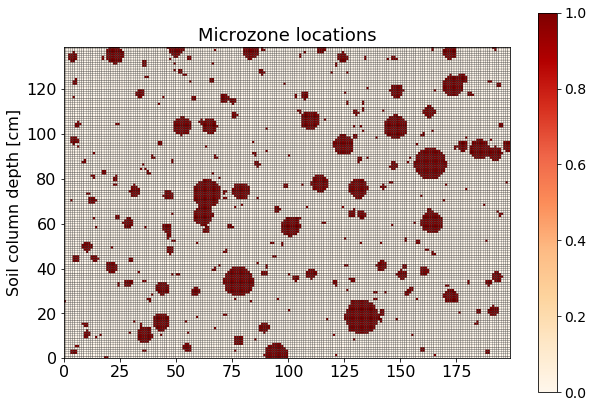

In [36]:
# Use our new plot function to illustrate the spatial distrubiton of microzones 
# 1s indicate microzones, 0s are matrix
plot_2d(microzone_map[0,:,:], x, y, '')
plt.title('Microzone locations', fontsize=18)
# plt.gca().invert_yaxis()

## Define MODFLOW/FloPy model function

We are now ready to build our reactive transport model using MODFLOW and MT3D (written and analyzed using FloPy). If you don't have FloPy setup then first work through the [MODFLOW, Python, and FloPy Setup notebook](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/MODFLOW%2C%20Python%2C%20and%20FloPy%20Setup.ipynb).

First find where you have your MODFLOW and MT3D executables located on your system.

In [11]:
# Path to MODFLOW executable, probably called 'mf2005'
exe_name_mf = 'C:\\Hydro\\MF2005.1_12\\MF2005.1_12\\bin\\mf2005'
# Print to make sure it is formated correctly
print(exe_name_mf)
# Path to MT3D executable, probably called 'mt3dms'
exe_name_mt = 'C:\\Hydro\\mt3dusgs1.1.0\\mt3dusgs1.1.0\\bin\\mt3d-usgs_1.1.0_64'
# Print to make sure it is formated correctly
print(exe_name_mt)

C:\Hydro\MF2005.1_12\MF2005.1_12\bin\mf2005
C:\Hydro\mt3dusgs1.1.0\mt3dusgs1.1.0\bin\mt3d-usgs_1.1.0_64


Let's create a new directory to save the data. 

In [12]:
# This should return a path to your current working directory
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises\Contaminant-Hydrogeology-Activities


In [13]:
# if this is not where you want to save stuff then change your directory using 'os.chdir()'
os.chdir('C:\\Users\\zahas\\Dropbox\\Teaching\\Contaminant hydro 629\\Modeling_excercises')
current_directory = os.getcwd()
print(current_directory)

C:\Users\zahas\Dropbox\Teaching\Contaminant hydro 629\Modeling_excercises


In [14]:
# now lets give a name to the directory to save data, this directory should be present in your 
# current working directory (but if it's not don't worry!)
directory_name = 'data_2D_model'
# Let's add that to the path of the current directory
workdir = os.path.join('.', directory_name)

# if the path exists then we will move on, if not then create a folder with the 'directory_name'
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
print("Directory '% s' created" % workdir) 

Directory '.\data_2D_model' created


In [15]:
# directory to save data
directory_name = 'microzones_2D_model'
# directory to save data
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')
workdir = os.path.join('.', directory_name)

Notice however that we don't yet name the folder where we will save data 'dirname'. This will be an input to our model function.


## 2D Reactions Model Function
The first thing we do is setup the function. This makes it easy to run repeated models and only change a few of the parameters that we are interested in. The boundary conditions are set so that our solute enters the model from the top and diffuses or advects downward. The underlying head conditions are set so that the bottom of the model is zero and the top of the model is defined by the desired advection rate (```v``` parameter below). The model currently has a homogenous hydraulic conductivity and porosity however this could be changed in the function to enable microzones to have different porosity and hydraulic conductivity.

### Function Input:
#### directory name
Example: ```direname = 'cool_model'```

#### MT3D period length 
Time is in selected units, the model time length is the sum of this (for steady state flow it can be set to anything). Note that this is different from the MODFLOW flow model period input. Therefore the underlying flow conditions are constant and steady state across changes in MT3D stress periods. The function is set up to only allow for one input period. For example: ```perlen_mt = [3600*24*365]```
    
#### Grid size 
Grid cell size in selected units. For example: ```grid_size = [0.25, 0.25]```
    
#### porosity
float or array of floats (nlay, nrow, ncol) describing the effective porosity. For example, ```prsity = 0.3```
    
#### advection velocity
Specific discharge divided by porosity in selected units. Zero is valid input. Example: ```v = 0.001``` 
    
#### dispersivity
float or array of floats (nlay, nrow, ncol). ```al``` is the longitudinal dispersivity, for every cell of the model grid (unit, L). Example: ```al = 0.2``` 
    
#### microzone (aggregate) effective molecular diffusion coefficient 
Example: ```Da = 1.0e-6```

#### matrix effective molecular diffusion coefficient 
Example: ```D = 1.0e-5```

#### inlet concentration
Example: ```C_in = 1.0```

#### numerical solution scheme
mixelm is an integer flag for the advection solution option. mixelm = 0 is the standard finite difference method with upstream or central in space weighting, this seems to work best for diffusion-only models. mixelm = 1 is the forward tracking method of characteristics, this seems to result in minimal numerical dispersion. mixelm = 2 is the backward tracking. mixelm = 3 is the hybrid method. mixelm = -1 is the third-ord TVD scheme (ULTIMATE) .Example: ```mixelm = 1```
  
### Reaction model input  
#### microzone map
This is an array of integers (nlay, nrow, ncol) with 1 indicate the presence of a microzone and zero indicating normal matrix. See functions above for examples of ```microzone_map ```

#### ireact 
ireact is an integer flag indicating which type of kinetic rate reaction is simulated: ireact = 0, no kinetic rate reaction is simulated; ireact = 1, first-order irreversible reaction, ireact = 100, zero-order reactions (decay or production). Note that this reaction package is not intended for modeling chemical reactions between species. An add-on reaction package developed specifically for that purpose may be used. (default is 0). Example: ```ireact = 1```

#### rc1 
float or array of floats (nlay, nrow, ncol)
rc1 is the first-order reaction rate for the dissolved (liquid) phase for the first species (unit, T-1). rc1 is not used ireact = 0. If a dual-domain system is simulated, the reaction rates for the liquid phase in the mobile and immobile domains are assumed to be equal. If rc1 is not specified and ireact > 0 then rc1 is set to 0. (default is None). Example: ```rc1 = 0.0001```


In [16]:
def microzone_model_2D(dirname, perlen_mt, grid_size, prsity, 
        v, al, Da, D, C_in, mixelm, microzone_map, ireact, rc1):
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)
    
    # time units (itmuni in discretization package), unfortunately this entered differently into MODFLOW and MT3D
    # 1 = seconds, 2 = minutes, 3 = hours, 4 = days, 5 = years
    itmuni = 1 # MODFLOW
    mt_tunit = 'S' # MT3D units
    # length units (lenuniint in discretization package)
    # 0 = undefined, 1 = feet, 2 = meters, 3 = centimeters
    lenuni = 3 # MODFLOW units
    mt_lunit = 'CM' # MT3D units
    
    # Modflow stress periods
    perlen_mf = [np.sum(perlen_mt)]
    # number of stress periods (MF input), calculated from period length input
    nper_mf = len(perlen_mf)
    
    # number of stress periods (MT input), calculated from period length input
    nper = len(perlen_mt)
    
    # Frequency of output, If nprs > 0 results will be saved at 
    #     the times as specified in timprs; 
    nprs = 20
    # timprs (list of float): The total elapsed time at which the simulation 
    #     results are saved. The number of entries in timprs must equal nprs. (default is None).
    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint=False)
    
    # Model information 
    model_shape = np.shape(microzone_map)
    nlay = model_shape[0] # number of layers
    nrow = model_shape[1] # number of rows
    ncol = model_shape[2] # number of columns
    delr = grid_size[0] # grid size in direction of Lx
    delc = grid_size[1] # grid size in direction of Ly, this was choosen such that the model has the same cross-sectional area as the column from the dispersion notebook example
    delv = 1.0 # grid size in direction of Lz
    laytyp = 0
    
    # length of model in selected units 
    Lx = (ncol - 1) * delr
    Ly = (nrow - 1) * delc
    
    # hydraulic conductivity
    hk = 1.
    # advection velocity (function input)
    # porosity (function input)
    # discharge (again in selected units)
    q = v * prsity
    
    # Flow field boundary conditions
    # boundary conditions, <0 = specified head, 0 = no flow, >0 variable head
    ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
    # index the inlet cell
    ibound[0, 0, :] = -1
    # index the outlet cell
    ibound[0, -1, :] = -1
    # constant head conditions
    strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
    h1 = q * Ly
    # index the inlet cell
    strt[0, -1, :] = h1
    print("Inlet head value: " + str(h1) + " (check units of 'lenuni')")
    
    # Solute transport diffusion and dispersion conditions
    # dmcoef is a float or array of floats (nlay) or (nlay, nrow, ncol) 
    # if the multiDiff option is used. DMCOEF is the effective molecular 
    # diffusion coefficient (unit, L2T-1). Set DMCOEF = 0 if the 
    # effect of molecular diffusion is considered unimportant. 
    # Each value in the array corresponds to one model layer. 
    # The value for dmcoef applies only to species 1. 
    # set diffusion of microzones
    microzone_diffusion = microzone_map * Da
    # set values of matrix to 1 and assign matrix diffusion values
    inverse_microzone_map = microzone_map +1
    inverse_microzone_map[inverse_microzone_map>1]=0
    matrix_diffusion = inverse_microzone_map * D
    # combine to set array of effective molecular 
    # diffusion coefficients
    dmcoef = microzone_diffusion + matrix_diffusion
    
    # Solute transport boundary conditions
    # Boundary conditions: if icbund = 0, the cell is an inactive concentration cell; 
    # If icbund < 0, the cell is a constant-concentration cell; 
    # If icbund > 0, the cell is an active concentration cell where the concentration value will be calculated.
    icbund = np.ones((nlay, nrow, ncol), dtype=np.int)

    # Initial conditions: concentration zero everywhere, except the inlet
    sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
    
    # MT3D stress period data, note that the indices between 'spd_mt' must exist in 'spd_mf' 
    # This is used as input for the source and sink mixing package
    # Itype is an integer indicating the type of point source, 2=well, 3=drain, -1=constant concentration
    itype = -1
    cwell_info = np.zeros((ncol, 5), dtype=np.float)
        
    # Nested loop to define every inlet face grid cell as a well
    for col in range(0, ncol):
        cwell_info[col] = [0, nrow-1, col, C_in, itype] 
      
    spd_mt = {0:cwell_info}
    
#     # Second stress period, uncomment if you want to change solute concentration      
#     cwell_info2 = cwell_info.copy()   
#     cwell_info2[:,3] = C_in[1] 
#     # Now apply stress period info    
#     spd_mt = {0:cwell_info, 1:cwell_info2}
    
    
    # Setup models
    # MODFLOW model name
    modelname_mf = dirname + '_mf'
    # MODFLOW package class
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    # MODFLOW model discretization package class
    dis = flopy.modflow.ModflowDis(mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper_mf,
                                   delr=delr, delc=delc, top=0., botm=[0 - delv],
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    # MODFLOW basic package class
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    # MODFLOW layer properties flow package class
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    # MODFLOW preconditioned conjugate-gradient package class
    pcg = flopy.modflow.ModflowPcg(mf)
    # MODFLOW Link-MT3DMS Package Class (this is the package for solute transport)
    lmt = flopy.modflow.ModflowLmt(mf)
    
    mf.write_input()
    mf.run_model(silent=True) # Set this to false to produce output in command window
    
    # RUN MT3dms solute tranport 
    modelname_mt = dirname + '_mt'
    # MT3DMS Model Class
    # Input: modelname = 'string', namefile_ext = 'string' (Extension for the namefile (the default is 'nam'))
    # modflowmodelflopy.modflow.mf.Modflow = This is a flopy Modflow model object upon which this Mt3dms model is based. (the default is None)
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, 
                           exe_name=exe_name_mt, modflowmodel=mf)  
    
    
    # Basic transport package class
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc, 
                             tunit=mt_tunit, lunit=mt_lunit, nper=nper, 
                             perlen=perlen_mt, nprs=nprs, timprs=timprs)
    
    # mixelm is an integer flag for the advection solution option, 
    # mixelm = 0 is the standard finite difference method with upstream or central in space weighting.
    # mixelm = 1 is the forward tracking method of characteristics, this seems to result in minimal numerical dispersion.
    # mixelm = 2 is the backward tracking
    # mixelm = 3 is the hybrid method
    # mixelm = -1 is the third-ord TVD scheme (ULTIMATE)
    
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    
    if np.prod(np.shape(dmcoef)) > 1:
        multiDiff=True
    else: 
        multiDiff=False
    
#     print(multiDiff)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, dmcoef=dmcoef, multiDiff=multiDiff)
    
    # =============================================================================    
    ## Note this additional line to call the reaction package
    rhob = 1.6
    rct = flopy.mt3d.Mt3dRct(mt, isothm=0, ireact=ireact, igetsc=0,
                             rhob=rhob, rc1=rc1)
    # =============================================================================
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.UcnFile(fname)
    # Extract the output time information, convert from list to np array
    times = np.array(ucnobj.get_times())
    # Extract the 4D concentration values (t, x, y, z)
    conc = ucnobj.get_alldata()
    
    return mf, mt, times, conc

In [37]:
# directory name
dirname = 'full_flow_model'
# Length of model run
perlen_mt = [60*60*24*30] # run for 1 month
# microzone diffusion
Da = 1.0E-6
# matrix diffusion
D = 7.6E-4
# inlet concentration
C_in = 1
# advection rate
v = 0.001
# dispersivity (dispersion equal to the product of v and al)
al = 0.2 # cm
prsity = 0.21
# numerical scheme
mixelm = -1

# ireact = 1 for first order, ireact = 100 for zero order
ireact = 100
zero_order_production = 2.0E-3 # I believe this will be in cm^-3.s^-1
rc1 = microzone_map*zero_order_production

In [38]:
mf, mt, times, conc = microzone_model_2D(dirname, perlen_mt, 
            grid_size, prsity, v, al, Da, D, C_in, mixelm,
            microzone_map, ireact, rc1)

print('Model output times (seconds):')
print(times)

.\microzones_2D_model\full_flow_model
Inlet head value: 0.02919 (check units of 'lenuni')
Model output times (seconds):
[      0.  129600.  259200.  388800.  518400.  648000.  777600.  907200.
 1036800. 1166400. 1296000. 1425600. 1555200. 1684800. 1814400. 1944000.
 2073600. 2203200. 2332800. 2462400. 2592000.]


(140, 200)


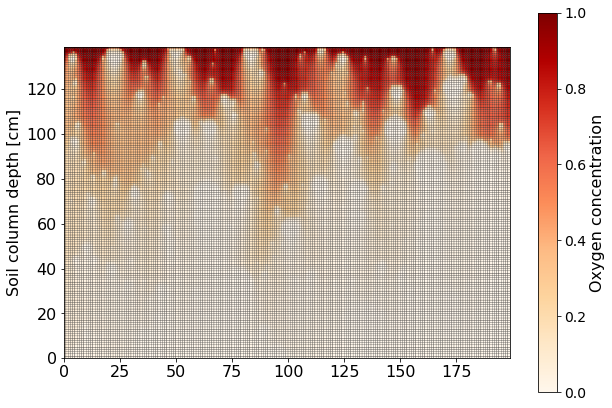

In [41]:
# Call our plotting function
plot_2d(conc[-1,0,:,:], x, y, 'Oxygen concentration')
plt.clim(0,1)
# plt.gca().invert_yaxis()


With the zero order term we are able to model oxygen consumption in the microzones and observe the impact on oxygen concentrations further down the soil column.

## Comparison of different diffusion rates
Now let's try to recreate figure 3 from [Smith, 1980 'A model of the extent of anaerobic zones in aggregated soils, and its potential application to estimates of denitrification'](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1365-2389.1980.tb02080.x)

In [20]:
# Microzone volume
print('microzone volume fraction: ' + 
      str(np.sum(microzone_map)/np.prod(np.shape(microzone_map))))

microzone volume fraction: 0.18435714285714286


(21, 1, 140, 200)


Text(0, 0.5, 'Concentration')

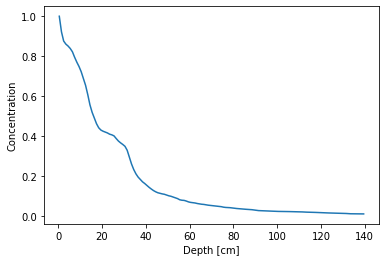

In [21]:
# Extract the model grid cell location (in selected units, cm in this case)
y = mf.dis.sr.ycenter
print(np.shape(conc))
# Extract the mean concentration profile
O2_C_profile = np.mean([conc[-1,0,:,:]], axis = 2)

plt.plot(y, O2_C_profile.T)
plt.xlabel('Depth [cm]')
plt.ylabel('Concentration')

In [22]:
# No flow, all diffusion
v = 0.000
mixelm = 0
# ireact = 1 for first order, ireact = 100 for zero order
ireact = 0
rc1 = 0

## line a ##
dirname = 'model_a'
mf, mt, times, conca = microzone_model_2D(dirname, perlen_mt, 
            grid_size, prsity, v, al, 1.0E-6, 7.6E-3, C_in, mixelm,
            microzone_map, ireact, rc1)
# Extract the mean concentration profile
O2_C_a = np.mean([conca[-1,0,:,:]], axis = 2)

## line b ##
dirname = 'model_b'
mf, mt, times, concb = microzone_model_2D(dirname, perlen_mt, 
            grid_size, prsity, v, al, 1.0E-6, 7.6E-4, C_in, mixelm,
            microzone_map, ireact, rc1)
# Extract the mean concentration profile
O2_C_b = np.mean([concb[-1,0,:,:]], axis = 2)

## line c ##
dirname = 'model_c'
mf, mt, times, concc = microzone_model_2D(dirname, perlen_mt, 
            grid_size, prsity, v, al, 1.0E-5, 7.6E-4, C_in, mixelm,
            microzone_map, ireact, rc1)
# Extract the mean concentration profile
O2_C_c = np.mean([concc[-1,0,:,:]], axis = 2)

## line d (anaerobic zones created with zero order term) ##
dirname = 'model_d'
# ireact = 1 for first order, ireact = 100 for zero order
ireact = 100
zero_order_production = 2.0E-1 # I believe this will be in cm^-3.s^-1
rc1 = microzone_map*zero_order_production

mf, mt, times, concd = microzone_model_2D(dirname, perlen_mt, 
            grid_size, prsity, v, al, 1.0E-6, 7.6E-4, C_in, mixelm,
            microzone_map, ireact, rc1)
# Extract the mean concentration profile
O2_C_d = np.mean([concd[-1,0,:,:]], axis = 2)


.\microzones_2D_model\model_a
Inlet head value: 0.0 (check units of 'lenuni')
.\microzones_2D_model\model_b
Inlet head value: 0.0 (check units of 'lenuni')
.\microzones_2D_model\model_c
Inlet head value: 0.0 (check units of 'lenuni')
.\microzones_2D_model\model_d
Inlet head value: 0.0 (check units of 'lenuni')


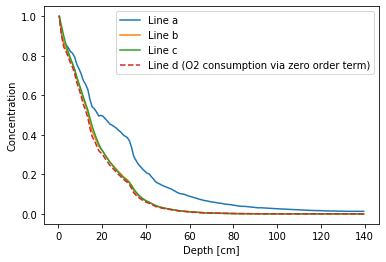

In [23]:
c1, = plt.plot(y, O2_C_a.T, label='Line a')
c2, = plt.plot(y, O2_C_b.T,  label='Line b')
c3, = plt.plot(y, O2_C_c.T, label='Line c')
c4, = plt.plot(y, O2_C_d.T, '--', label='Line d (O2 consumption via zero order term)')
plt.xlabel('Depth [cm]')
plt.ylabel('Concentration')
plt.legend(handles=[c1, c2, c3, c4])

These are the profiles after a month of transport by only diffusion. 